In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Description des données

Les données cliniques ont été fournies au format tabulé (.tsv).  
Une attention particulière a été portée au séparateur lors de l’import afin d’éviter des erreurs de parsing.


In [ ]:
#chargement des données
df = pd.read_csv('aml_tcga_gdc_clinical_data.csv', sep="\t") # séparateur de tabulations


#Aperçu des premières lignes
print("Aperçu des premières lignes :")
print(df.head())

#Dimensions et types de colonnes
print("\nDimensions du DataFrame :")
print(df.shape)

print("\nTypes des colonnes :")
print(df.dtypes)

Aperçu des premières lignes :
       Study ID    Patient ID        Sample ID  Diagnosis Age  Biopsy Site  \
0  aml_tcga_gdc  TCGA-AB-2802  TCGA-AB-2802-03             50  Bone Marrow   
1  aml_tcga_gdc  TCGA-AB-2803  TCGA-AB-2803-03             61  Bone Marrow   
2  aml_tcga_gdc  TCGA-AB-2804  TCGA-AB-2804-03             30  Bone Marrow   
3  aml_tcga_gdc  TCGA-AB-2805  TCGA-AB-2805-03             76  Bone Marrow   
4  aml_tcga_gdc  TCGA-AB-2806  TCGA-AB-2806-03             46  Bone Marrow   

              Cancer Type    Cancer Type Detailed  \
0  Acute Myeloid Leukemia  Acute Myeloid Leukemia   
1  Acute Myeloid Leukemia  Acute Myeloid Leukemia   
2  Acute Myeloid Leukemia  Acute Myeloid Leukemia   
3  Acute Myeloid Leukemia  Acute Myeloid Leukemia   
4  Acute Myeloid Leukemia  Acute Myeloid Leukemia   

   Last Communication Contact from Initial Pathologic Diagnosis Date  \
0                                                NaN                   
1                                     

## Analyse des valeurs manquantes

Certaines variables présentent un nombre important de valeurs manquantes, notamment les variables temporelles (dates de contact, date de décès) et certaines variables biologiques (TMB, mutation count).  
Ces absences sont cohérentes avec le contexte clinique (patients vivants, examens non réalisés) et seront prises en compte lors de l’étape de prétraitement.

Les valeurs manquantes sont inspectées variable par variable afin d’évaluer la qualité des données et d’anticiper les stratégies de prétraitement.


In [91]:
missing_values = df.isnull().sum().sort_values(ascending=False)

print("Valeurs manquantes par colonne :")
missing_values


Valeurs manquantes par colonne :


Last Communication Contact from Initial Pathologic Diagnosis Date    132
Mutation Count                                                       129
TMB (nonsynonymous)                                                  128
Death from Initial Pathologic Diagnosis Date                          80
Overall Survival (Months)                                             12
Ethnicity Category                                                     3
Race Category                                                          2
Patient Primary Tumor Site                                             1
Biopsy Site                                                            1
Study ID                                                               0
Birth from Initial Pathologic Diagnosis Date                           0
Cancer Type                                                            0
Diagnosis Age                                                          0
Is FFPE                                            

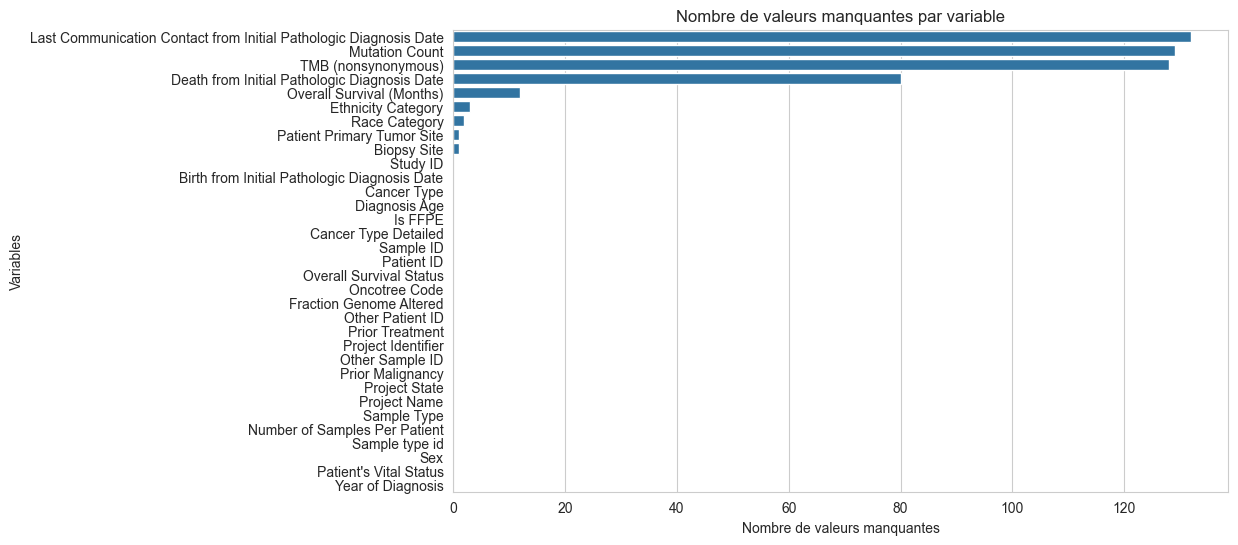

In [92]:
# représentation graphique
plt.figure(figsize=(10,6))
sns.barplot(x=missing_values.values, y=missing_values.index)
plt.title("Nombre de valeurs manquantes par variable")
plt.xlabel("Nombre de valeurs manquantes")
plt.ylabel("Variables")
plt.show()

In [93]:
# remplacer les valeurs manquantes par la moyenne
df["Overall Survival (Months)"] = df["Overall Survival (Months)"].fillna(df["Overall Survival (Months)"].mean())


In [94]:
cols_to_drop = [
    'Study ID', 'Patient ID', 'Sample ID',  
       'Last Communication Contact from Initial Pathologic Diagnosis Date',
       'Birth from Initial Pathologic Diagnosis Date',
       'Death from Initial Pathologic Diagnosis Date', 'Ethnicity Category',
        'Oncotree Code','Other Patient ID', 'Other Sample ID', 'Patient Primary Tumor Site',
       'Project Identifier',
       'Project Name', 'Project State', 'Race Category',
       'Number of Samples Per Patient', 'Sample Type', 'Sample type id', 'TMB (nonsynonymous)', 'Mutation Count',
       'Is FFPE', 'Biopsy Site', 'Cancer Type', 'Cancer Type Detailed', 'Overall Survival Status'
        ]
      



df = df.drop(columns=cols_to_drop, errors="ignore")


# Encodage des variables

In [95]:
df.dtypes

Diagnosis Age                  int64
Fraction Genome Altered      float64
Overall Survival (Months)    float64
Prior Malignancy                bool
Prior Treatment                 bool
Sex                              str
Patient's Vital Status           str
Year of Diagnosis              int64
dtype: object

In [96]:
# Encodage des variables qualitatives (passage en category)
for col in [
    "Sex", "Patient's Vital Status"]:
    df[col] = df[col].astype("category")

df.dtypes

Diagnosis Age                   int64
Fraction Genome Altered       float64
Overall Survival (Months)     float64
Prior Malignancy                 bool
Prior Treatment                  bool
Sex                          category
Patient's Vital Status       category
Year of Diagnosis               int64
dtype: object

# Analyse univariée

### Variable dépendante

In [97]:
# Distribution de la variable cible (target)
df["Patient's Vital Status"].value_counts(normalize=True)

Patient's Vital Status
Dead     0.665
Alive    0.335
Name: proportion, dtype: float64

La variable cible (Overall Survival Status) présente un certain déséquilibre, ce qui devra être pris en compte lors de l’évaluation des modèles. La distribution de la variable cible montre un déséquilibre de classes modéré, avec environ 66,5 % de patients décédés et 33,5 % de patients vivants.
Ce déséquilibre sera pris en compte lors de l’évaluation des modèles, notamment à travers des métriques adaptées au contexte clinique.

### Variables quantitatives

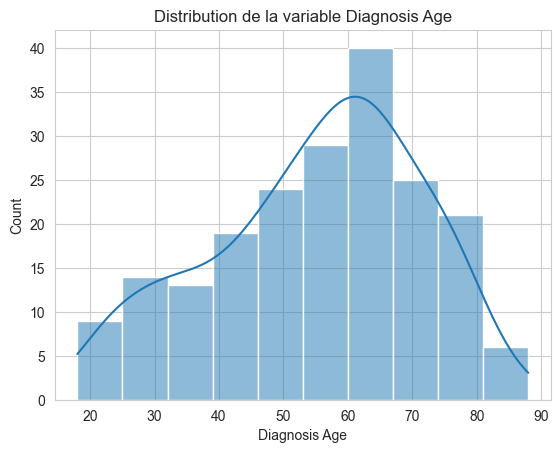

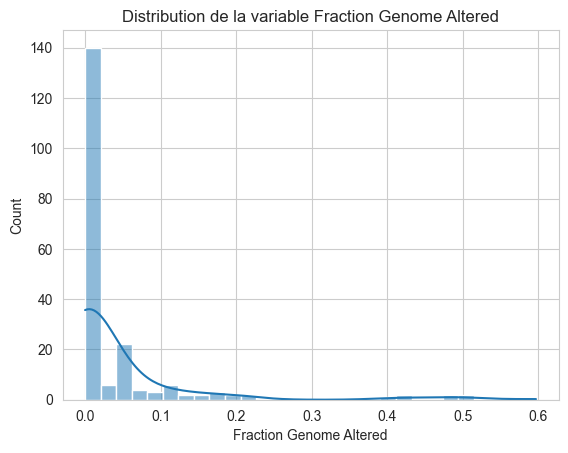

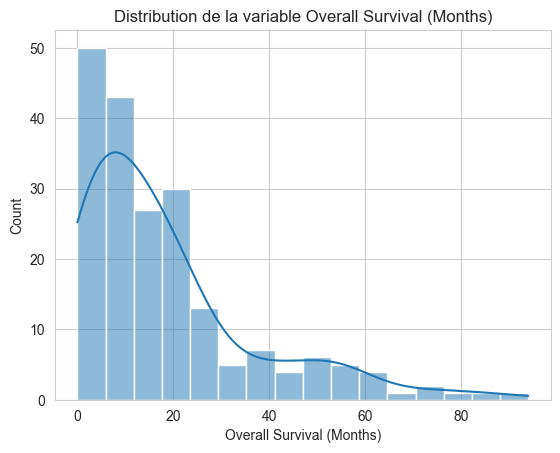

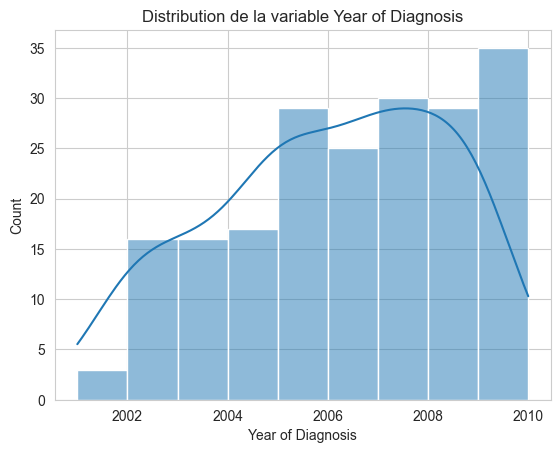

In [98]:
# Histogramme pour voir les distributions
nums_var = df.select_dtypes(include=['float64', 'int64']).columns

for i in nums_var : 
    plt.figure()
    sns.histplot(df[i], kde=True)
    plt.title(f'Distribution de la variable {i}')
    plt.show()

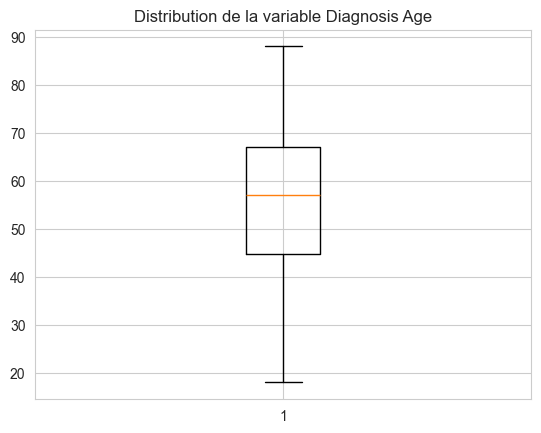

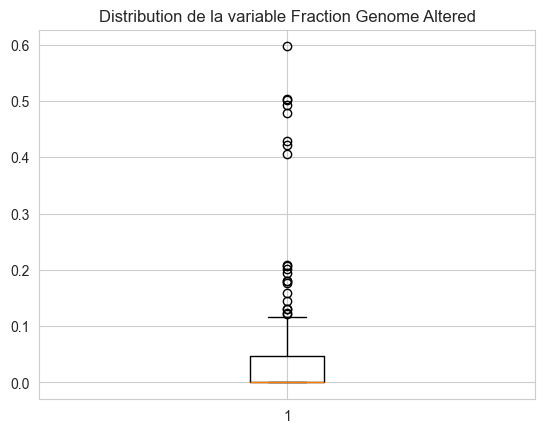

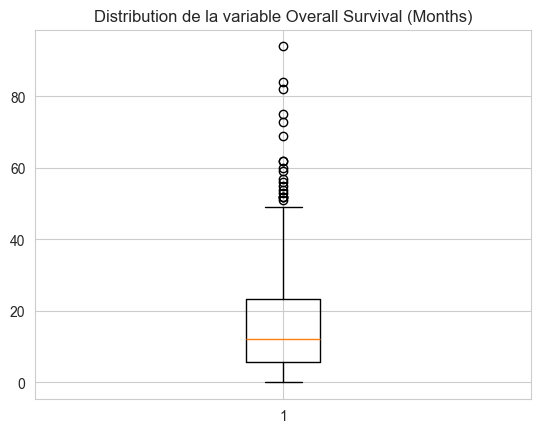

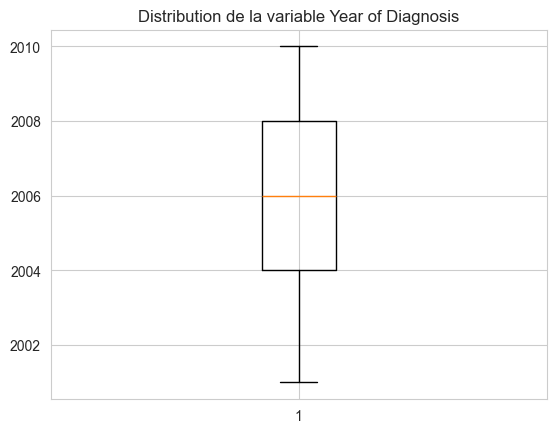

In [99]:
#Outliers

for i in nums_var : 
    plt.figure()
    plt.boxplot(df[i])
    plt.title(f'Distribution de la variable {i}')
    plt.show()

In [100]:
# enlever les outliers pour la variable overall survival et fraction genome

Q1 = df[nums_var].quantile(0.15)
Q3 = df[nums_var].quantile(0.85)
IQR = Q3 - Q1

df_clean = df[~((df[nums_var] < (Q1 - 1.5 * IQR)) |(df[nums_var] > (Q3 + 1.5 * IQR))).any(axis=1)] #on a enlevé 13 obs

### Variables qualitatives

C:\Users\Emma\AppData\Local\Temp\ipykernel_772\3757314378.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


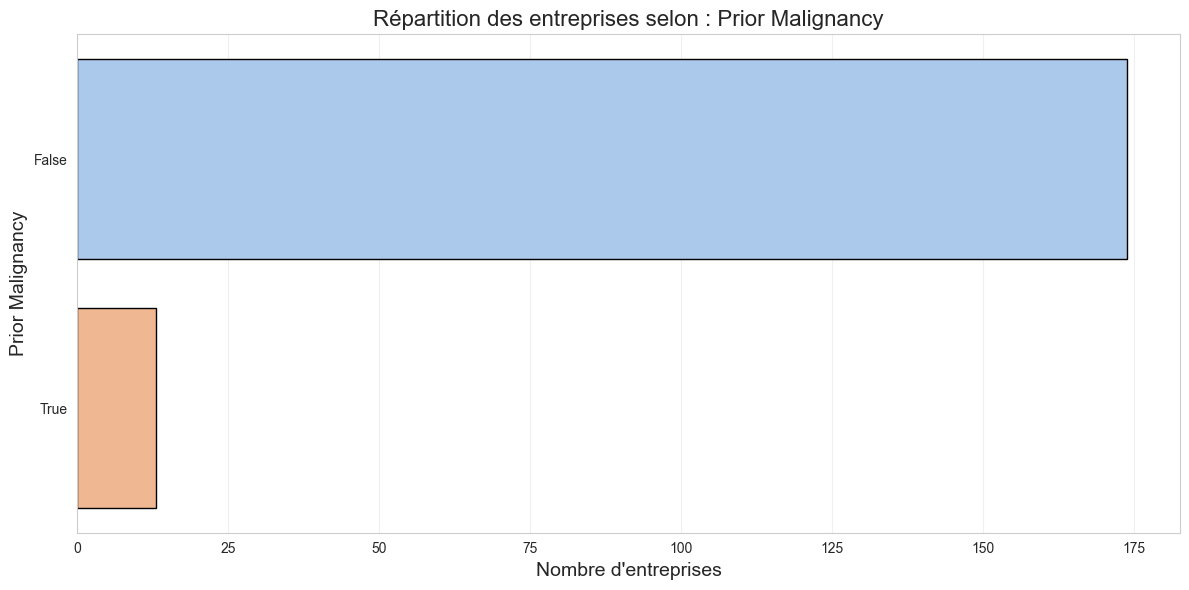

C:\Users\Emma\AppData\Local\Temp\ipykernel_772\3757314378.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


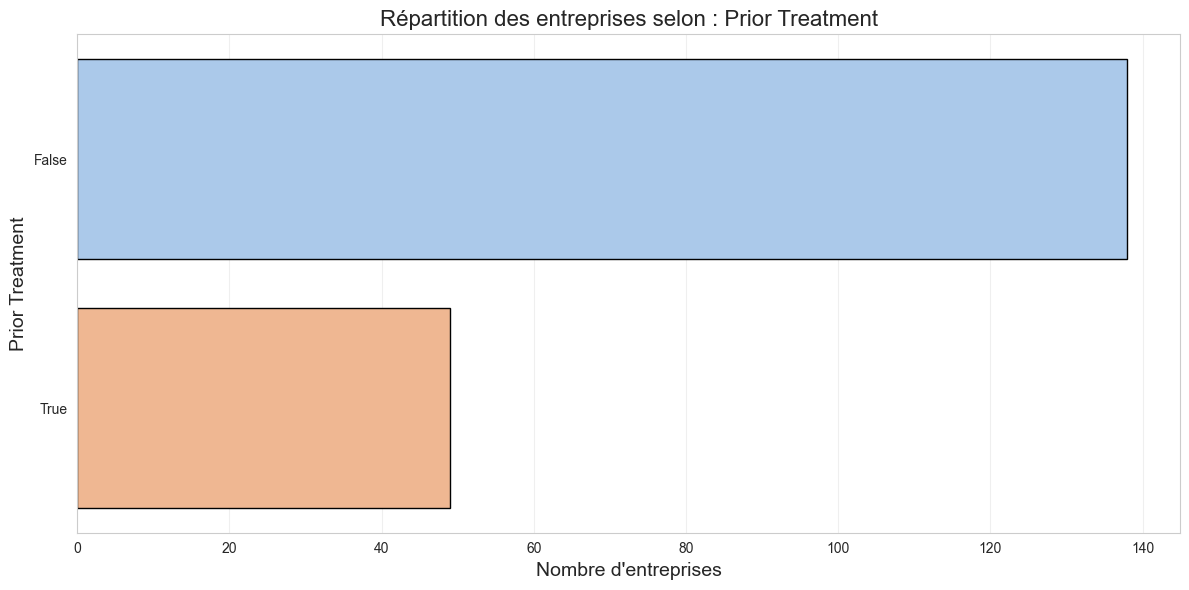

C:\Users\Emma\AppData\Local\Temp\ipykernel_772\3757314378.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


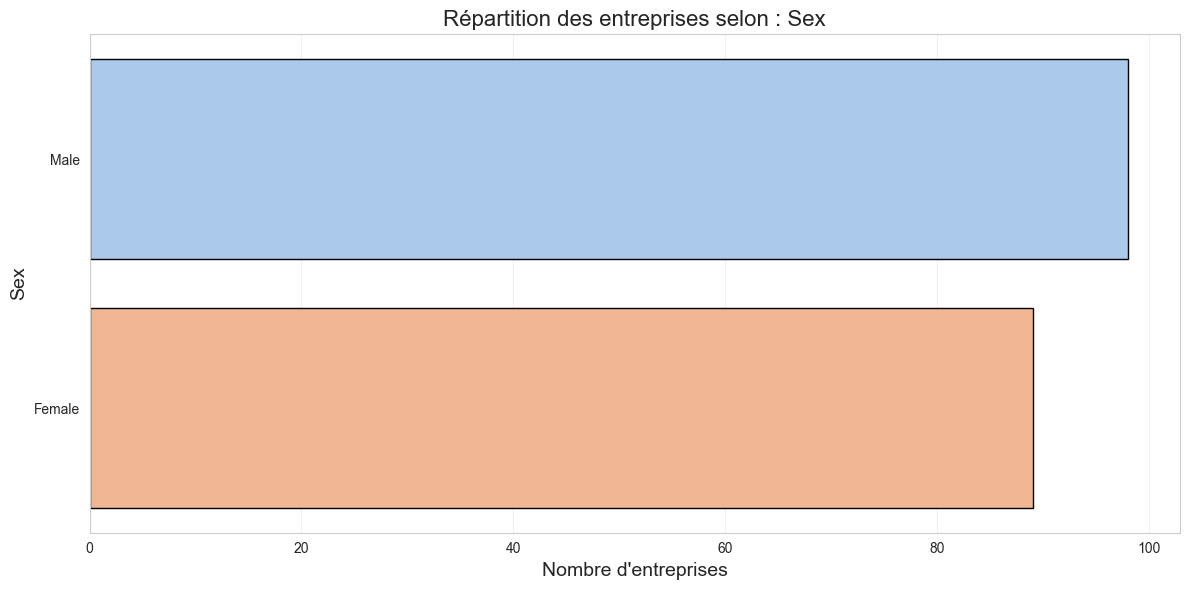

C:\Users\Emma\AppData\Local\Temp\ipykernel_772\3757314378.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


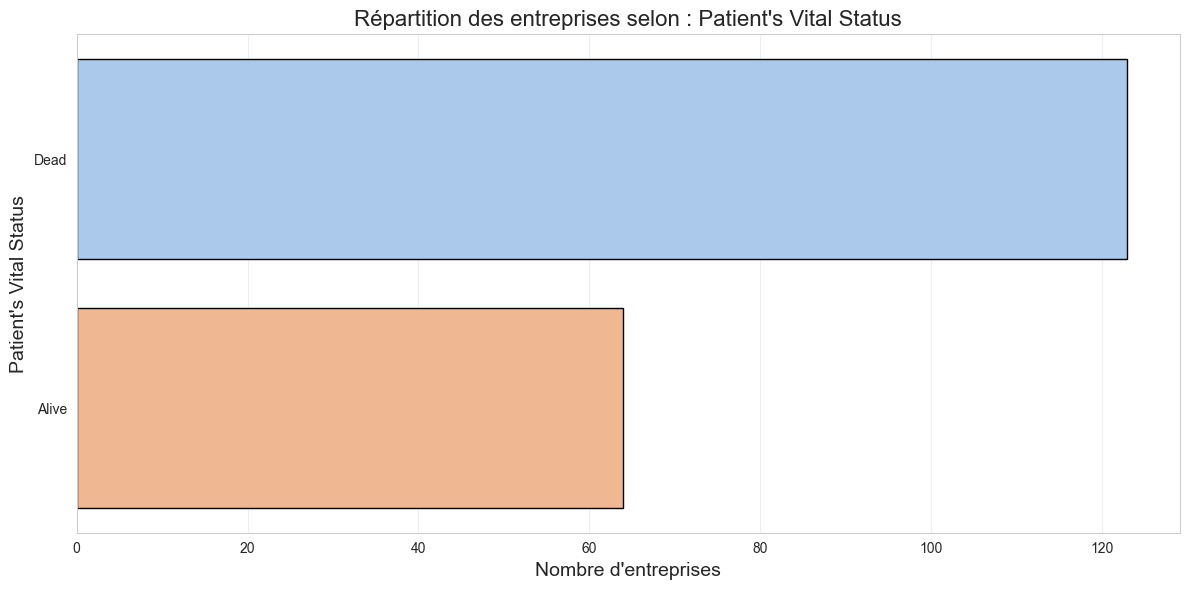

In [101]:
# Attention tu travailles avec df_clean maintenant
# Liste des colonnes catégorielles
cat_var = df_clean.select_dtypes(include=['bool', 'category']).columns # ENLEVE TA VARIABLE Y ON A DEJA FAIT AU DESUS

# Style seaborn
sns.set_style("whitegrid")

# Boucle pour créer un graphique pour chaque variable
for col in cat_var:
    plt.figure(figsize=(12,6))
    
    # Barplot avec comptage
    sns.countplot(
        data=df_clean,
        y=col,                  # y pour horizontal = lisible si beaucoup de catégories
        order=df_clean[col].value_counts().index,  # tri par fréquence
        palette="pastel",       
        edgecolor="black"
    )
    
    # Titres et labels
    plt.title(f"Répartition des entreprises selon : {col}", fontsize=16)
    plt.xlabel("Nombre d'entreprises", fontsize=14)
    plt.ylabel(col, fontsize=14)
    
    # Grille pour lisibilité
    plt.grid(axis="x", alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Analyse bivriée

In [102]:
df_clean[nums_var].corr() #très faible corrélation (essaye de l'améliorer niveau visuel)

,Diagnosis Age,Fraction Genome Altered,Overall Survival (Months),Year of Diagnosis
Diagnosis Age,1.000000,0.104957,-0.297710,0.020622
Fraction Genome Altered,0.104957,1.000000,-0.111790,0.072276
Overall Survival (Months),-0.297710,-0.111790,1.000000,-0.342263
Year of Diagnosis,0.020622,0.072276,-0.342263,1.000000


# Train Test Split

In [103]:
from sklearn.model_selection import train_test_split

X = df_clean.drop(columns=["Patient's Vital Status"])   
y = df_clean["Patient's Vital Status"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Encodage des variables 

In [104]:
# Mapping binaire
sex_mapping = {"Male": 1, "Female": 0}
vital_mapping = {"Dead": 1, "Alive": 0}

#sex
sex_mapping = {"Male": 1, "Female": 0}

X_train["Sex"] = X_train["Sex"].map(sex_mapping)
X_test["Sex"] = X_test["Sex"].map(sex_mapping)

#patient status
vital_mapping = {"Dead": 1, "Alive": 0}

y_train = y_train.map(vital_mapping)
y_test = y_test.map(vital_mapping)


# Modèle de Maachine learning

## XGBOOST

In [105]:
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report
)
import matplotlib.pyplot as plt


xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="binary:logistic",
    eval_metric="logloss"
)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

In [106]:
print("XGBoost Classification")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))


XGBoost Classification
Accuracy: 0.8421052631578947

Classification report:

              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.89      0.89      0.89        27

    accuracy                           0.84        38
   macro avg       0.81      0.81      0.81        38
weighted avg       0.84      0.84      0.84        38



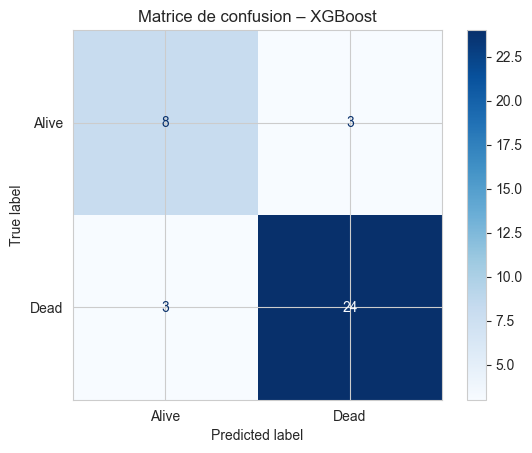

In [ ]:
#Graphique
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Alive", "Dead"]
)

disp.plot(cmap="Blues")
plt.title("Matrice de confusion – XGBoost")
plt.show()


# Ton texte 

L’analyse exploratoire des données cliniques de patients atteints de leucémie aiguë myéloïde a permis d’identifier plusieurs variables pertinentes pour la prédiction du statut de survie globale.

L’étude de la variable cible met en évidence un déséquilibre modéré entre les patients décédés et vivants, justifiant l’utilisation de métriques adaptées lors de la phase de modélisation.

L’analyse des variables numériques montre que l’âge au diagnostic, la charge mutationnelle et la fraction du génome altéré présentent des distributions différentes selon le statut de survie, suggérant un potentiel intérêt pronostique. Ces résultats sont cohérents avec les connaissances cliniques actuelles en hématologie, où ces facteurs sont fréquemment associés à l’évolution de la maladie.

Concernant les variables catégorielles, le sexe ne semble pas constituer un facteur discriminant majeur, tandis que la variable Prior Treatment apparaît fortement associée à un pronostic défavorable, reflétant probablement des formes plus avancées ou réfractaires de la maladie. La variable Prior Malignancy montre également une tendance vers une survie diminuée, bien que le faible effectif de cette sous-population impose une interprétation prudente.

Dans l’ensemble, cette analyse exploratoire a permis de sélectionner un ensemble restreint de variables cliniquement pertinentes et exploitables pour la modélisation. Ces variables seront utilisées lors de l’étape suivante de préprocessing et de préparation des données, en portant une attention particulière à la gestion des valeurs manquantes, à l’encodage des variables catégorielles et à la prévention du data leakage.